In [1]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.5 MB/s 
     |████████████████████████████████| 8.2 MB 29.9 MB/s 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import re
import nltk
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [3]:
nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Анализ данных

In [4]:
drive.mount('/content/drive/')
train = pd.read_csv('/content/drive/MyDrive/Sber/train_data.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/Sber/test_data.csv', index_col='id')

Mounted at /content/drive/


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1669 non-null   object
 1   label     1669 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.1+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10571 entries, 0 to 10569
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10570 non-null  float64
 1   title       10364 non-null  object 
 2   text        10569 non-null  object 
dtypes: float64(1), object(2)
memory usage: 330.3+ KB


In [7]:
train['label'].value_counts()

0    1340
1     329
Name: label, dtype: int64

Первая проблема тренировочной выборки, которая бросается в глаза: это дисбаланс классов. Для улучшения качества необходимо устранить эту проблему. В другом ноутбуке я решаю её при помощи перефразирования.

Необходимо узнать длину строк в тренировочной и тестовой частях, чтобы понять, какое значение max_len утсанавливать для BERT

Max len train: 120


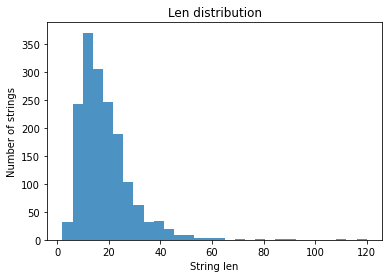

In [8]:
train_len = [len(i.split()) for i in train['sentence']]

print('Max len train:', max(train_len))
plt.hist(train_len, bins=30, alpha=0.8)
plt.title('Len distribution')
plt.xlabel('String len')
plt.ylabel('Number of strings');

Max len texts in test: 1489


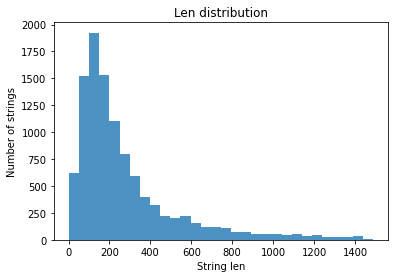

In [9]:
test_len = [len(str(i).split()) for i in test['text']]

print('Max len texts in test:', max(test_len))
plt.hist(test_len, bins=30, alpha=0.8)
plt.title('Len distribution')
plt.xlabel('String len')
plt.ylabel('Number of strings');

Max len texts in test: 39


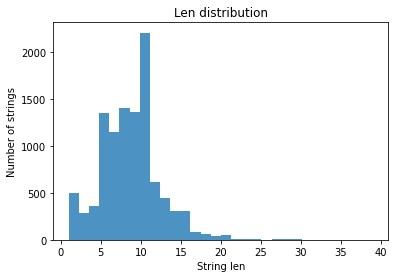

In [11]:
test_title_len = [len(str(i).split()) for i in test['title']]

print('Max len texts in test:', max(test_title_len))
plt.hist(test_title_len, bins=30, alpha=0.8)
plt.title('Len distribution')
plt.xlabel('String len')
plt.ylabel('Number of strings');

Некоторые строки в тестовой части получаются слишком длинными. Но BERT может принимать на вход только 512 токенов, эту проблему я буду решать при помощи разбиения длинных строк на мини-батчи по 512 токенов.

#Очистка данных

In [126]:
train_copy = train.copy()
test_copy = test.copy()

Проверим, есть ли пустые строки

In [146]:
train_copy[train_copy['sentence'] == ' '].index

Int64Index([], dtype='int64')

In [147]:
test_copy[test_copy['text'] == ' '].index

Index([], dtype='object', name='id')

In [148]:
test_copy[test_copy['title'] == ' '].index

Index([], dtype='object', name='id')

Функция для лемматизации и удаления стоп-слов

In [69]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', str(doc))
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

In [128]:
train_copy['sentence'] = train_copy['sentence'].apply(lemmatize)
test_copy['text'] = test_copy['text'].apply(lemmatize)
test_copy['title'] = test_copy['title'].apply(lemmatize)

In [144]:
train_copy.to_csv('train_cleaned.csv')
test_copy.to_csv('test_cleaned.csv')

#Вычисляем схожесть текстов новостей и заголовков

Как видно, в тестовых данных помимо текста новостей есть ещё и заголовок. Моя идея заключается в том, чтобы при классификации использовать и текст новости, и заголовок одновременно, как одну последовательность. Такой подход может ухудшить качество модели, если заголовки и новости слишком схожи между собой. Проверим сходство заголовков и текстов при помощи косинусного расстояния.

In [130]:
train_copy.fillna('текст', inplace=True)
test_copy.fillna('текст', inplace=True)

In [127]:
def concatenate(x):
  string = ' '.join(x)
  return string

In [131]:
train_copy['sentence'] = train_copy['sentence'].apply(concatenate)
test_copy['text'] = test_copy['text'].apply(concatenate)
test_copy['title'] = test_copy['title'].apply(concatenate)

In [133]:
texts = test_copy['text'].to_list()
titles = test_copy['title'].to_list()

In [115]:
def cosine(text, title):
  text_title = [text, title]
  vectorizer = CountVectorizer().fit_transform(text_title)
  vecs = vectorizer.toarray()
  text_vec, title_vec = vecs[0].reshape(1, -1), vecs[1].reshape(1, -1)
  csim = cosine_similarity(text_vec, title_vec)
  return csim[0][0]

In [140]:
cosines = []
for i in tqdm(range(len(texts))):
  cosine_sim = cosine(texts[i], titles[i])
  cosines.append(cosine_sim)

100%|██████████| 10571/10571 [00:15<00:00, 687.06it/s]


Посчитаем среднее косинусное расстояние. Оно получилось не очень большим. Помимо этого проверим сколько есть экземпляров с высоким косинусным расстоянием

In [143]:
sum(cosines) / len(cosines)

0.29506576419198893

In [153]:
big_cosines = len([item for item in cosines if item > 0.7])
big_cosines

78

Из 10 тысяч высокая схожесть есть только у 78 пар, это маленькое значение, которое существенно не повлияет на качество модели. Из этого можно сделать вывод, что заголовки и тексты новостей содержат разные слова, которые будут полезны для модели. Поэтому в модель можно подавать текст и заголовок как разные последовательности